In [2]:
# 1) Proper preprocessing for DenseNet201 and separate, non-augmented validation gen
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

DATASET_PATH = "C:/Users/yagni/Downloads/dataset/Citrus Leaf Disease Image"
IMG_SIZE = 256
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # <-- match DenseNet201 preprocessing
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

# Validation generator: NO augmentation, same split/seed
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Classes:", class_indices)

# 2) Optional: class weights for imbalance
y_train = train_generator.classes
classes = np.arange(num_classes)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=y_train)
class_weights = {i:w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

# 3) Model (DenseNet201 head)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=base_model.input, outputs=output)

model1.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# 4) Callbacks: LR scheduler and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

# 5) Train head
history1 = model1.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator,
    class_weight=class_weights,      # remove if not desired
    callbacks=callbacks
)

# 6) Fine-tune: unfreeze and recompile with low LR
base_model.trainable = True
model1.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])  # recompile after unfreezing

history2 = model1.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator, 
    class_weight=class_weights,
    callbacks=callbacks
)

# 7) Evaluate + diagnostics
loss, acc = model1.evaluate(val_generator)
print(f"Validation accuracy: {acc*100:.2f}%")


Found 489 images belonging to 5 classes.
Found 118 images belonging to 5 classes.
Classes: {'Black spot': 0, 'Canker': 1, 'Greening': 2, 'Healthy': 3, 'Melanose': 4}
Class weights: {0: np.float64(0.7191176470588235), 1: np.float64(0.7465648854961832), 2: np.float64(0.5963414634146341), 3: np.float64(2.0808510638297872), 4: np.float64(8.89090909090909)}


C:\Users\yagni\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - accuracy: 0.4438 - loss: 1.5458 - val_accuracy: 0.8220 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.8057 - loss: 0.5606 - val_accuracy: 0.8051 - val_loss: 0.4730 - learning_rate: 0.0010
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.8446 - loss: 0.2999 - val_accuracy: 0.8729 - val_loss: 0.3818 - learning_rate: 0.0010
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9223 - loss: 0.2009 - val_accuracy: 0.9322 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9346 - loss: 0.1637 - val_accuracy: 0.9322 - val_loss: 0.2751 - learning_rate: 0.0010
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9448 - loss: 0.1463 - val_accuracy: 0.8983 - val_loss: 0.3007 - learning_rate: 0.0010
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9591 - loss: 0.1253 - val_accuracy: 0.9407

In [3]:
# Optional: Save model
model1.save("citrus_leaf_disease_dense_model.h5")

In [12]:
from ipyfilechooser import FileChooser
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt

# Load model
model1 = tf.keras.models.load_model("citrus_leaf_disease_dense_model.h5")
class_labels = ['Canker', 'Melanose', 'Greening', 'Healthy', 'Black spot']
IMG_SIZE = 256

# Create file chooser widget
fc = FileChooser()
display(fc)

FileChooser(path='C:\Users\yagni', filename='', title='', show_hidden=False, select_desc='Select', change_desc…

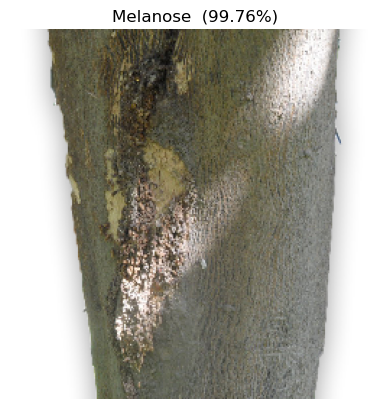

🖼️ Image (1).jpg → Melanose (confidence: 99.76%)


In [15]:
import os
file_path = fc.selected

if file_path:
    img = image.load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predict
    probs = model1.predict(x, verbose=0)
    top = int(np.argmax(probs))
    pred, conf = class_labels[top], float(probs[0, top])

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{pred}  ({conf*100:.2f}%)")
    plt.show()

    print(f"🖼️ {os.path.basename(file_path)} → {pred} (confidence: {conf*100:.2f}%)")
else:
    print("❌ No file selected.")


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities for validation data
Y_pred = model1.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report (Precision, Recall, F1-score per class)
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 10s/step
Confusion Matrix:
[[31  0  2  0  0]
 [ 2 29  1  0  0]
 [ 0  0 40  0  0]
 [ 0  1  2  8  0]
 [ 0  0  0  0  2]]
Classification Report:
              precision    recall  f1-score   support

  Black spot       0.94      0.94      0.94        33
      Canker       0.97      0.91      0.94        32
    Greening       0.89      1.00      0.94        40
     Healthy       1.00      0.73      0.84        11
    Melanose       1.00      1.00      1.00         2

    accuracy                           0.93       118
   macro avg       0.96      0.91      0.93       118
weighted avg       0.94      0.93      0.93       118

